# Machine Learning Assessment

## Initialise

Import calls.

In [15]:
%%writefile init.py

import pandas as pd

def init_calls() :
    # Convert to pandas DataFrame
    calls_df = pd.read_csv('./data/calls.csv')
    # print(calls_df.info())
    # print(calls_df.head(1))

    calls_df['Datetime'] = pd.to_datetime(calls_df['Datetime'],\
                                      format="%m/%d/%Y %I:%M:%S %p").dt.tz_localize(tz='US/Pacific', ambiguous='NaT')
    calls_df.dropna(inplace=True)
    calls_df.set_index('Datetime', inplace=True)
    calls_df.sort_index(inplace=True)

    # results_df['type'] = results_df['type'].astype('category')

    # print(calls_df.info())
    # print(calls_df.head(2))
    # print(calls_df.tail(2))
    
    return(calls_df)


Overwriting init.py


Import weather data.

In [16]:
%%writefile -a init.py

def init_weather() :
    wtr_df = pd.read_csv('./data/Seattle Weatherdata 2002 to 2020.csv')
    wtr_df['datetime'] = pd.to_datetime(wtr_df['dt'], unit='s').\
    dt.tz_localize(tz='UTC').\
    dt.tz_convert('US/Pacific')
    wtr_df.set_index('datetime', inplace=True)

    # wtr_df.info()
    # wtr_df.head(2)
    
    return(wtr_df)


Appending to init.py


In [17]:
%%writefile -a init.py

def init() :
    calls_df = init_calls()
    wtr_df = init_weather()
    
    x_raw = wtr_df[['temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'weather_id']]
    # x_raw.drop_duplicates(inplace=True)

    y_raw = calls_df['Incident Number'].resample('H').count().to_frame('incident_count')
    xy_df = y_raw.join(x_raw.index.isocalendar())
    xy_df['hour'] = xy_df.index.hour
    xy_df = xy_df.join(x_raw).dropna()

    xy_df.drop_duplicates(inplace=True)

    # print(xy_df.info())

    return(xy_df)


Appending to init.py


## Preprocessing

In [1]:
# %% writefile prep.py
import pandas as pd
import init

xy_df = init.init()

x_tr = xy_df.loc['2016':'2020'].iloc[:, 1:]
x_te = xy_df.loc['2015'].iloc[:, 1:]
y_tr = xy_df.loc['2016':'2020'].iloc[:, 0]
y_te = xy_df.loc['2015'].iloc[:, 0]

## Model

## Training

In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg_all = LinearRegression()
reg_all.fit(x_tr, y_tr)
y_pd = reg_all.predict(x_te)
print(reg_all.score(x_te, y_te))
print(np.sqrt(mean_squared_error(y_te, y_pd)))

0.19944645495353563
4.603590211724585


                           prediction  incident_count
2015-01-01 00:00:00-08:00    8.235248              37
2015-01-01 01:00:00-08:00    8.515270              28
2015-01-01 02:00:00-08:00    8.738371              30
2015-01-01 03:00:00-08:00    8.655652              17
2015-01-01 04:00:00-08:00    8.962906              11
...                               ...             ...
2015-12-31 19:00:00-08:00   13.873018              15
2015-12-31 20:00:00-08:00   14.132451              13
2015-12-31 21:00:00-08:00   13.900934              20
2015-12-31 22:00:00-08:00   14.167635              12
2015-12-31 23:00:00-08:00   13.839267              20

[8760 rows x 2 columns]


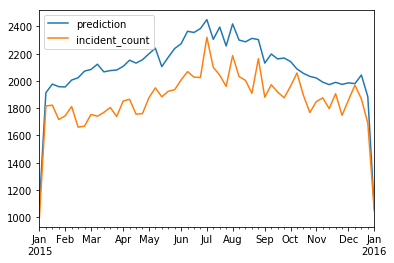

In [7]:
import matplotlib.pyplot as plt

ress = pd.DataFrame(data=y_pd, index=y_te.index, columns=['prediction']).join(y_te)
print(ress)
ress.resample('W').sum().plot()
plt.show()

In [10]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_classification
# from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
ppl = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
# The pipeline can be used as any other estimator
# and avoids leaking the test set into the train set
ppl.fit(x_tr, y_tr)
ppl.score(x_te, y_te)

0.10422374429223745

## Testing

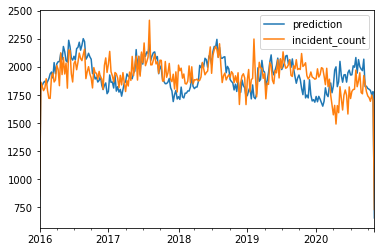

In [8]:
y_pd1 = reg_all.predict(x_tr)
pd.DataFrame(data=y_pd1, index=y_tr.index, columns=['prediction']).join(y_tr).resample('W').sum().plot()
plt.show()

                           prediction  incident_count
2015-01-01 00:00:00-08:00           7              37
2015-01-01 01:00:00-08:00           7              28
2015-01-01 02:00:00-08:00           7              30
2015-01-01 03:00:00-08:00           7              17
2015-01-01 04:00:00-08:00           7              11
...                               ...             ...
2015-12-31 19:00:00-08:00          13              15
2015-12-31 20:00:00-08:00          13              13
2015-12-31 21:00:00-08:00          10              20
2015-12-31 22:00:00-08:00          10              12
2015-12-31 23:00:00-08:00          10              20

[8760 rows x 2 columns]


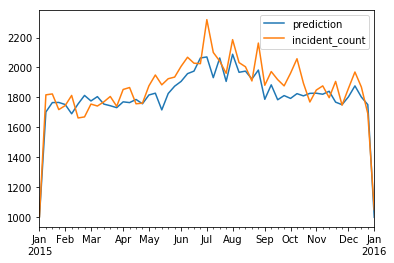

In [11]:
y_pdp = ppl.predict(x_te)
ressp = pd.DataFrame(data=y_pdp, index=y_te.index, columns=['prediction']).join(y_te)
print(ressp)
ressp.resample('W').sum().plot()
plt.show()

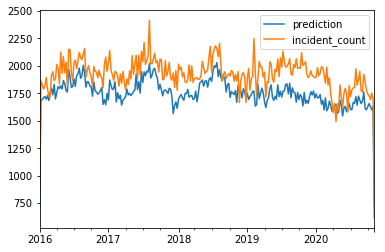

In [12]:
y_pd1p = ppl.predict(x_tr)
pd.DataFrame(data=y_pd1p, index=y_tr.index, columns=['prediction']).join(y_tr).resample('W').sum().plot()
plt.show()